In [1]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

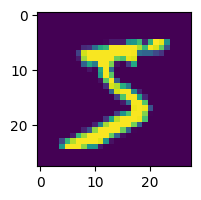

In [3]:
plt.figure(figsize = (15,2))
plt.imshow(X_train[0])

In [4]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [5]:
X_train = X_train.reshape((60000, 28, 28, 1))

In [6]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [7]:
X_test = X_test.reshape((10000, 28, 28, 1))

In [8]:
y_train[0]

5

In [9]:
np.max(X_train), np.max(X_test)

(255, 255)

In [10]:
X_train_sc = X_train/255
X_test_sc = X_test/255

In [11]:
np.max(X_train_sc), np.max(X_test_sc)

(1.0, 1.0)

In [12]:
# Data Augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

cnn = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    data_augmentation,
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = cnn.fit(X_train_sc, y_train, epochs=15, validation_split=0.2, batch_size=128)

# Evaluate the model
test_loss, test_accuracy = cnn.evaluate(X_test_sc, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5000 - loss: 1.4394 - val_accuracy: 0.9604 - val_loss: 0.1281
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8660 - loss: 0.4401 - val_accuracy: 0.9702 - val_loss: 0.0944
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9128 - loss: 0.2968 - val_accuracy: 0.9757 - val_loss: 0.0776
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9293 - loss: 0.2392 - val_accuracy: 0.9804 - val_loss: 0.0632
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9388 - loss: 0.2148 - val_accuracy: 0.9818 - val_loss: 0.0589
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9477 - loss: 0.1790 - val_accuracy: 0.9817 - val_loss: 0.0600
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9519 - loss: 0.1639 - val_accuracy: 0.9826 - val_loss: 0.0568
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9562 - loss: 0.1530 - val_acc

In [13]:
# Save the model
cnn.save('cnn_model.keras')

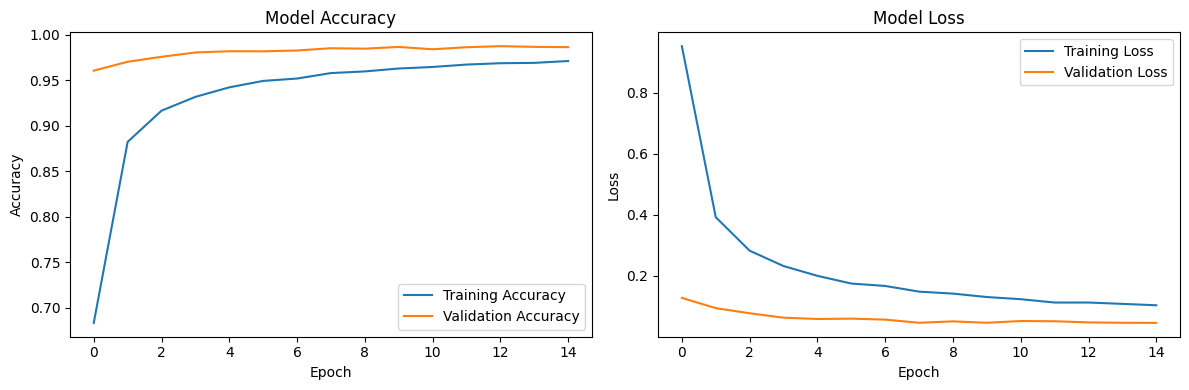

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
import cv2
model = tf.keras.models.load_model('cnn_model.keras')

# Initialize the camera
cap = cv2.VideoCapture(1)  # Use 0 for default camera


2024-09-27 15:28:27.645 python[76435:1807562] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [16]:

def preprocess_frame(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Resize to 28x28
    resized = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_AREA)
    
    # Normalize the image
    normalized = resized.astype('float32') / 255.0
    
    return normalized

In [17]:
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to capture frame")
        break
    
    # Preprocess the frame
    processed = preprocess_frame(frame)
    
    # Reshape for model input
    input_data = processed.reshape(1, 28, 28, 1)
    
    # Make prediction
    prediction = model.predict(input_data, verbose=0)
    digit = np.argmax(prediction)
    confidence = np.max(prediction)
    
    # Display the result on the frame if confidence is high enough
    if confidence > 0.7:
        cv2.putText(frame, f"Digit: {digit}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(frame, "No confident prediction", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the preprocessed image
    cv2.imshow('Preprocessed', processed)
    
    # Display the frame
    cv2.imshow('Real-time Digit Recognition', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()